# Cornell Demo
DB Seminar, Spring 2022.
Rolando Garcia, UC Berkeley.
rogarcia@berkeley.edu

# <- What's in the repo?
0. This is a vanilla Jupyter Notebook, running on VSCode
1. Show README
2. Let's see some code

# -> Lets see train_rnn.py

We can also characterize the train_rnn.py code as follows:
```python
import flor
import torch

trainloader: torch.utils.data.DataLoader
testloader:  torch.utils.data.DataLoader
optimizer:   torch.optim.Optimizer
net:         torch.nn.Module
criterion:   torch.nn._Loss

for epoch in flor.it(range(...)):
    if flor.SkipBlock.step_into('training_loop'):
        for data in trainloader:
            inputs, labels = data
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            print(f"loss: {loss.item()}")
    flor.SkipBlock.end(net, optimizer)
    eval(net, testloader)
```

Brief overview of Record-Replay.
* Record:
    * `flor.SkipBlock.end` serializes and writes partial checkpoint
    * auto-commit changes to repository (special branch)
* Replay:
    * `flor.it` restores its starting state from checkpoint (parallelism)
    * `flor.SkipBlock` may skip, and load side-effects instead from disk (memoization)

# "I don't want to learn a new API"
# -> flor has hands-free mode
Side-by-side comparison. I want to show you what I'm doing.
```bash
python -c "import flor; flor.transformer.Transform('...')
```

# "I don't want this to slow training"
# -> Overhead is negligible
Fast Record (<6% overhead): Buffering, Write-Behind, Background Serialization/IO, Physiological Logging
![Record Plot](doc/img/record.png)
Figure from [Garcia et al. VLDB'21]

# Flor & Git
Model developers iterate quickly to try many ideas. We want to store every version of model training tried. Autocommit
* Show timeline

In [ ]:
!git log

In [3]:
!python -m flor unpack

copied 891435432eb68ca13e41a34b2c64a796109719d0::2022-02-10T03:31:32.json
copied 1d9548175d55eb0ec9b43c66035d7960dbed2aac::2022-02-10T03:29:39.json
copied dda00f2f9c985089a1cee13ed0e7b1b7be58a3ce::2022-02-10T03:28:43.json
copied 5ac088ba2760dfe16dbd7c7e4887c0fa44a130d4::2022-02-10T03:27:54.json
copied 5e835c3f6990c6667c2f9d36047b8bf89c171687::2022-02-10T03:26:27.json
copied d9973057cb00a470ab29763679fd8d7f84eec1b0::2022-02-10T03:25:23.json
copied 9a517185de46fc5d93bb5bb233500b0e446b787f::2022-02-10T03:24:09.json
copied b1c1e7d3f37c819867baec0b51864c253cdf480f::2022-02-10T03:23:19.json
copied 05751709ecb8adeaa4b2589bfe8598039f185e33::2022-02-10T03:22:25.json
copied b1ff2adfaa917d2b5d991e072509c910d673e2a7::2022-02-10T03:21:24.json
copied 0a56d9d7d109bad175cd87f7c1c8674a071733d8::2022-02-10T03:20:08.json
copied 710c7e1edf9275df50c96de14aa5d0170ff12bc2::2022-02-10T03:18:41.json
copied 0ac9f4abf185c4b8cde2f0955938c66e851602c0::2022-02-10T03:17:06.json
copied 06e583145f3b8942a216965d449e5a3

# Let's explore the Model Training History
Exploratory model development

In [2]:
import flor
import numpy as np

Fact table with all the data logged so far:

In [3]:
raw_df = flor.load_kvs()
raw_df

,projid,vid,tstamp,alpha,epoch,step,name,value
6505,kaggle-nlp-disasters,dcb7bd24785e68784ef28bb4711036b271e28366,2022-02-09 17:11:16,a,0,0,clf_seed,3890
6506,kaggle-nlp-disasters-rnn,9f2a0688cee1cd94edd465b0c6ad4fe11dd97406,2022-02-09 17:13:01,a,1,0,avg_train_loss,0.692024
6508,kaggle-nlp-disasters-rnn,9f2a0688cee1cd94edd465b0c6ad4fe11dd97406,2022-02-09 17:13:01,a,1,0,average_valid_loss,0.681677
6507,kaggle-nlp-disasters-rnn,9f2a0688cee1cd94edd465b0c6ad4fe11dd97406,2022-02-09 17:13:01,a,1,1,avg_train_loss,0.688612
6509,kaggle-nlp-disasters-rnn,9f2a0688cee1cd94edd465b0c6ad4fe11dd97406,2022-02-09 17:13:01,a,1,1,average_valid_loss,0.680252
...,...,...,...,...,...,...,...,...
1480,kaggle-nlp-disasters-rnn,891435432eb68ca13e41a34b2c64a796109719d0,2022-02-10 03:31:32,a,79,1,average_valid_loss,0.507055
1481,kaggle-nlp-disasters-rnn,891435432eb68ca13e41a34b2c64a796109719d0,2022-02-10 03:31:32,a,80,0,avg_train_loss,0.502675
1483,kaggle-nlp-disasters-rnn,891435432eb68ca13e41a34b2c64a796109719d0,2022-02-10 03:31:32,a,80,0,average_valid_loss,0.506836
1482,kaggle-nlp-disasters-rnn,891435432eb68ca13e41a34b2c64a796109719d0,2022-02-10 03:31:32,a,80,1,avg_train_loss,0.520349


### -> The table is populated with logged data
Let's see the logging statements in train_rnn.py

In [4]:
df = raw_df[['tstamp', 'epoch', 'step', 'name', 'alpha', 'value']]
df

,tstamp,epoch,step,name,alpha,value
6505,2022-02-09 17:11:16,0,0,clf_seed,a,3890
6506,2022-02-09 17:13:01,1,0,avg_train_loss,a,0.692024
6508,2022-02-09 17:13:01,1,0,average_valid_loss,a,0.681677
6507,2022-02-09 17:13:01,1,1,avg_train_loss,a,0.688612
6509,2022-02-09 17:13:01,1,1,average_valid_loss,a,0.680252
...,...,...,...,...,...,...
1480,2022-02-10 03:31:32,79,1,average_valid_loss,a,0.507055
1481,2022-02-10 03:31:32,80,0,avg_train_loss,a,0.502675
1483,2022-02-10 03:31:32,80,0,average_valid_loss,a,0.506836
1482,2022-02-10 03:31:32,80,1,avg_train_loss,a,0.520349


In [5]:
record_df = df[['tstamp', 'epoch', 'step', 'name', 'value']][df['alpha'] == 'a']
replay_df = df[['tstamp', 'epoch', 'step', 'name', 'value']][df['alpha'] == 'b']
record_df['name'].unique(), replay_df['name'].unique() # What did I log in the past? What did the other students log?

(array(['clf_seed', 'avg_train_loss', 'average_valid_loss', 'best_acc',
        'best_loss', 'hindsight-logged-val'], dtype=object),
 array([], dtype=object))

In [6]:
# import plotly.express as px

df = record_df
avg_train_loss = df[df['name'] == 'avg_train_loss']
avg_train_loss_agg = avg_train_loss.groupby(['tstamp', 'epoch']).agg({'value': 'mean'}).reset_index()
avg_train_loss_agg['tstamp'] = avg_train_loss_agg['tstamp'].map(str)
avg_train_loss_agg # Rollup
# fig = px.line_3d(avg_train_loss_agg, x='tstamp', y='epoch', z='value', color='tstamp')
# fig.show()

,tstamp,epoch,value
0,2022-02-09 17:13:01,1,0.690318
1,2022-02-09 17:13:01,2,0.686117
2,2022-02-09 17:13:01,3,0.684030
3,2022-02-09 17:13:01,4,0.680108
4,2022-02-09 17:13:01,5,0.678496
...,...,...,...
1755,2022-02-10 03:31:32,76,0.504667
1756,2022-02-10 03:31:32,77,0.510805
1757,2022-02-10 03:31:32,78,0.498961
1758,2022-02-10 03:31:32,79,0.513081


In [7]:
import matplotlib.pyplot as plt

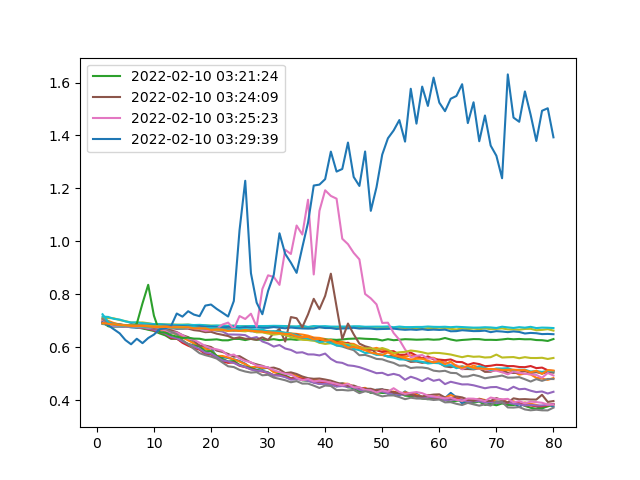

In [8]:
%matplotlib widget
fig = plt.figure()
ax = plt.subplot()
for t in avg_train_loss_agg['tstamp'].drop_duplicates().values:
    df = avg_train_loss_agg[avg_train_loss_agg['tstamp'] == t]
    if any(df['value'] > 0.8):
        ax.plot(df['epoch'], df['value'], label=t)
    else:
        ax.plot(df['epoch'], df['value'])
ax.legend()
plt.show()



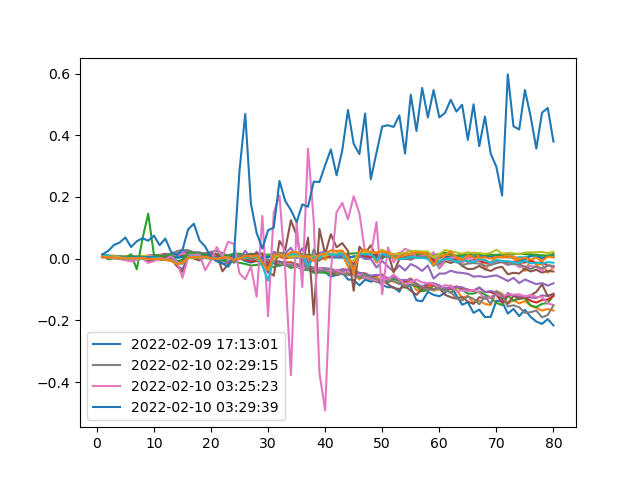

In [9]:
%matplotlib widget
df = record_df
avg_val_loss = df[df['name'] == 'average_valid_loss']
avg_valid_loss_agg = avg_val_loss.groupby(['tstamp', 'epoch']).agg({'value': 'mean'}).reset_index()
avg_valid_loss_agg['tstamp'] = avg_valid_loss_agg['tstamp'].map(str)
avg_valid_loss_agg

m_df =  avg_train_loss_agg.merge(avg_valid_loss_agg, on=['tstamp', 'epoch'])
m_df['diff'] = m_df['value_x'] - m_df['value_y']                                # train_loss - val_loss
m_df

fig = plt.figure()
ax = plt.subplot()
for t in m_df['tstamp'].drop_duplicates().values:
    df = m_df[m_df['tstamp'] == t]
    if any(df['diff'].map(abs) > 0.19):
        ax.plot(df['epoch'], df['diff'], label=t)
    else:
        ax.plot(df['epoch'], df['diff'], label=None)
ax.legend()
plt.show()

# Let's do some hindsight logging
* Skip Retraining when possible
    * Use memoization: observe physical-logical equivalence
* Parallelize Retraining otherwise
    * Enable resuming from a checkpoint
    * Work Partitioning: Control the epoch sub-range from the command-line

### -> Add print statement and replay latest version
And show mechanics of code below.
What does it do?

In [ ]:
df = raw_df = flor.load_kvs()
record_df = df[['tstamp', 'epoch', 'step', 'name', 'value']][df['alpha'] == 'a']
replay_df = df[['tstamp', 'epoch', 'step', 'name', 'value']][df['alpha'] == 'b']
record_df['name'].unique(), replay_df['name'].unique() # What did I log in the past? What did the other students log?

In [10]:
# Which versions have I replayed?
replay_df[replay_df['name'] == 'learning_rate']['tstamp'].unique()

array(['2022-02-07T20:42:25.000000000', '2022-02-10T03:25:23.000000000',
       '2022-02-10T03:29:39.000000000', '2022-02-10T03:31:32.000000000'],
      dtype='datetime64[ns]')

### -> Propagate logging statements back in time
And show mechanics of code below.
What does it do?

In [ ]:
raw_df[['tstamp', 'vid']][
    raw_df['tstamp'] >= np.Datetime64('2022-02-10')
    ].drop_duplicates()

In [ ]:
!python -m flor stage train_rnn.py

In [ ]:
!git checkout d9973057cb00a470ab29763679fd8d7f84eec1b0

In [ ]:
!python -m flor propagate train_rnn.py

In [ ]:
!python train_rnn.py --replay_flor